# <center> Stroke Prediction </center>
#### <center> Zach Hanson </center>

## Import Libraries and Data

### Libraries

In [1]:
#Pandas, numpy, matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Seaborn for better visual on graphs
import seaborn as sns
#Default theme as seaborn
sns.set_theme()

### Data

In [2]:
#Loading in data
filename = 'healthcare-dataset-stroke-data.csv'
df = pd.read_csv(filename)

In [3]:
#Checking to see if loaded properly
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


- Looks to be loaded properly

## Data Cleaning

### Removing Unnecessary Columns

In [4]:
df = df.drop(columns = 'id')
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


- ID column was dropped successfully
  - This column is not important to predicting stroke risk as each identifier will be different

### Removing Unnecessary Rows

In [5]:
duprow = df.duplicated().sum()
print(f"There are {duprow} duplicated rows.")

There are 0 duplicated rows.


### Missing Values

In [6]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

- The only missing values in this data set are in the "bmi" column.
- This will be addressed later using an imputer during our model creations.

### Inconsistencies in Data

#### Gender

In [7]:
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

- No inconsistencies in this column.

#### Ever Married

In [8]:
df['ever_married'].value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

- No inconsistencies in this column.

#### Work Type

In [9]:
df['work_type'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

- No inconsistencies in this column.

#### Residence Type

In [10]:
df['Residence_type'].value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

- No inconsistencies in this column.

#### Smoking Status

In [11]:
df['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

- No inconsistencies in this column.

## Exploratory Analysis

In [12]:
#Copying data frame to prevent data leakage
ea_df = df.copy()

#Checking to see if it copied correctly
ea_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


- Looks to be copied correctly

### Categorical Features

C:\Users\Zach\AppData\Local\Temp\ipykernel_19272\4212449645.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp1.set_xticklabels(sp1.get_xticklabels(),
C:\Users\Zach\AppData\Local\Temp\ipykernel_19272\4212449645.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp2.set_xticklabels(sp2.get_xticklabels(),
C:\Users\Zach\AppData\Local\Temp\ipykernel_19272\4212449645.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp3.set_xticklabels(sp3.get_xticklabels(),
C:\Users\Zach\AppData\Local\Temp\ipykernel_19272\4212449645.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp4.set_xticklabels(sp4.get_xticklabels(),
C:\Users\Zach\AppData\Local\Temp\ipykernel_19272\4212449645.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp5.set_xticklabels(sp5.get_xticklabels(),


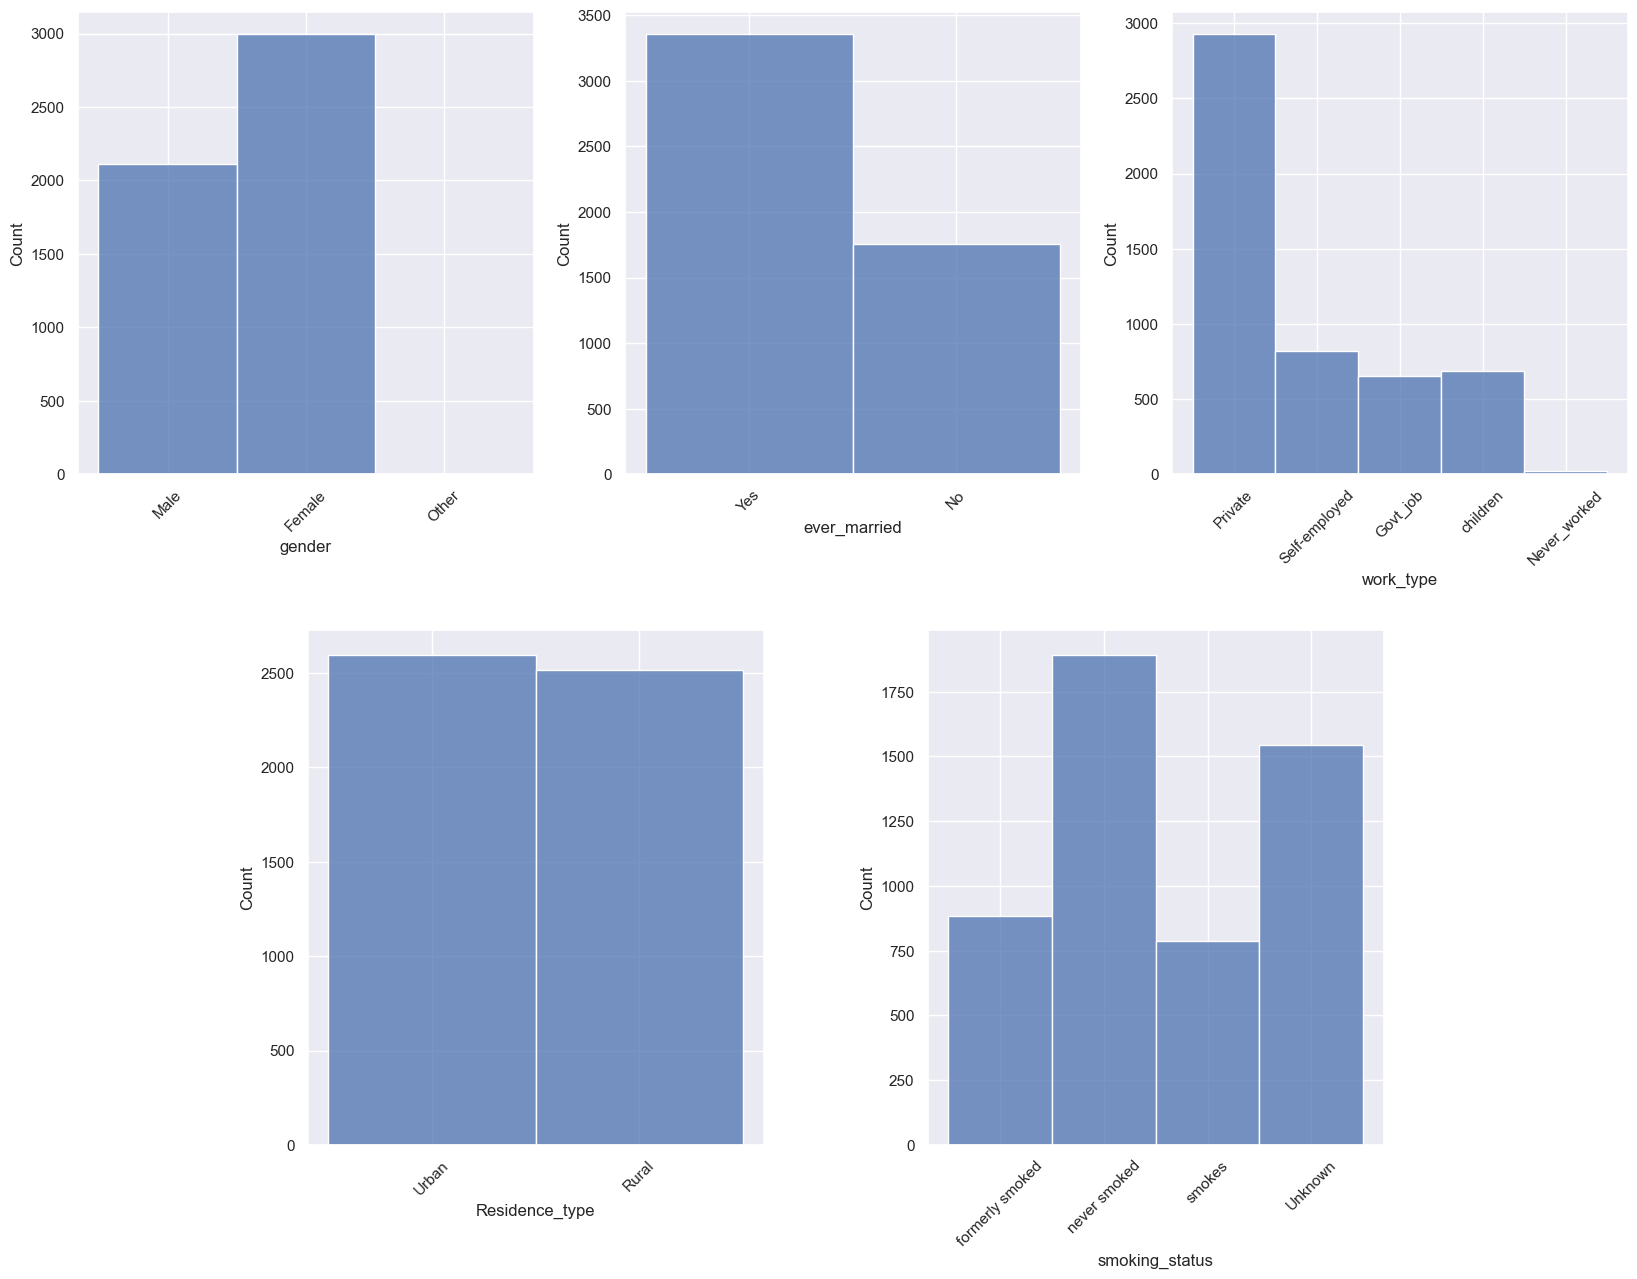

In [13]:
#Creating Subplot for features
fig, ax = plt.subplots(nrows = 2,              #Number of Rows
                         ncols = 3,            #Number of Columns
                         figsize = (20, 15))   #Size of each subplot


#Adding Gender subplot
sp1 = sns.histplot(ax = ax[0][0], data = ea_df, x = 'gender');

#Adding married subplot
sp2 = sns.histplot(ax = ax[0][1], data = ea_df, x = 'ever_married')

#Adding work type subplot
sp3 = sns.histplot(ax = ax[0][2], data = ea_df, x = 'work_type')

#Adding residence type subplot
sp4 = sns.histplot(ax = ax[1][0], data = ea_df, x = 'Residence_type')

#adding smoking status subplot
sp5 = sns.histplot(ax = ax[1][1], data = ea_df, x = 'smoking_status')


#Adding space between subplots for readability
fig.subplots_adjust(hspace = 0.5)

#Rotating tick labels for readability
sp1.set_xticklabels(sp1.get_xticklabels(),
                    rotation = 45);
sp2.set_xticklabels(sp2.get_xticklabels(),
                    rotation = 45);
sp3.set_xticklabels(sp3.get_xticklabels(),
                    rotation = 45);
sp4.set_xticklabels(sp4.get_xticklabels(),
                    rotation = 45);
sp5.set_xticklabels(sp5.get_xticklabels(),
                    rotation = 45);


#Since we only need 5 subplots, hiding 6th one
ax[1][2].set_visible(False)
#Moving bottom two subplots to be more centered for better viewing
ax[1][0].set_position([0.24, 0.125, 0.228, 0.343])
ax[1][1].set_position([0.55, 0.125, 0.228, 0.343])

- Code for the positioning of subplots 4 and 5 was taken from: https://stackoverflow.com/questions/26767281/position-5-subplots-in-matplotlib

- Gender
    - We have a fairly even split of male/female, with slightly more females.
- Ever Married
    - We have about double the amount of people who were married vs. not married.
- Job Type
    - Many of the responses chose to not disclose their job type
    - People who did respond have a very even split between self employed, government job, and stay-at-home parents, with a very small amount of people who have not worked.
- Residence Type
    - Very even split between urban and rural residence
- Smoking Status
    - About half of the people who responded to this have never smoked
    - The other half is fairly evenly split between currently smokes and formerly smokes

### Numerical Features

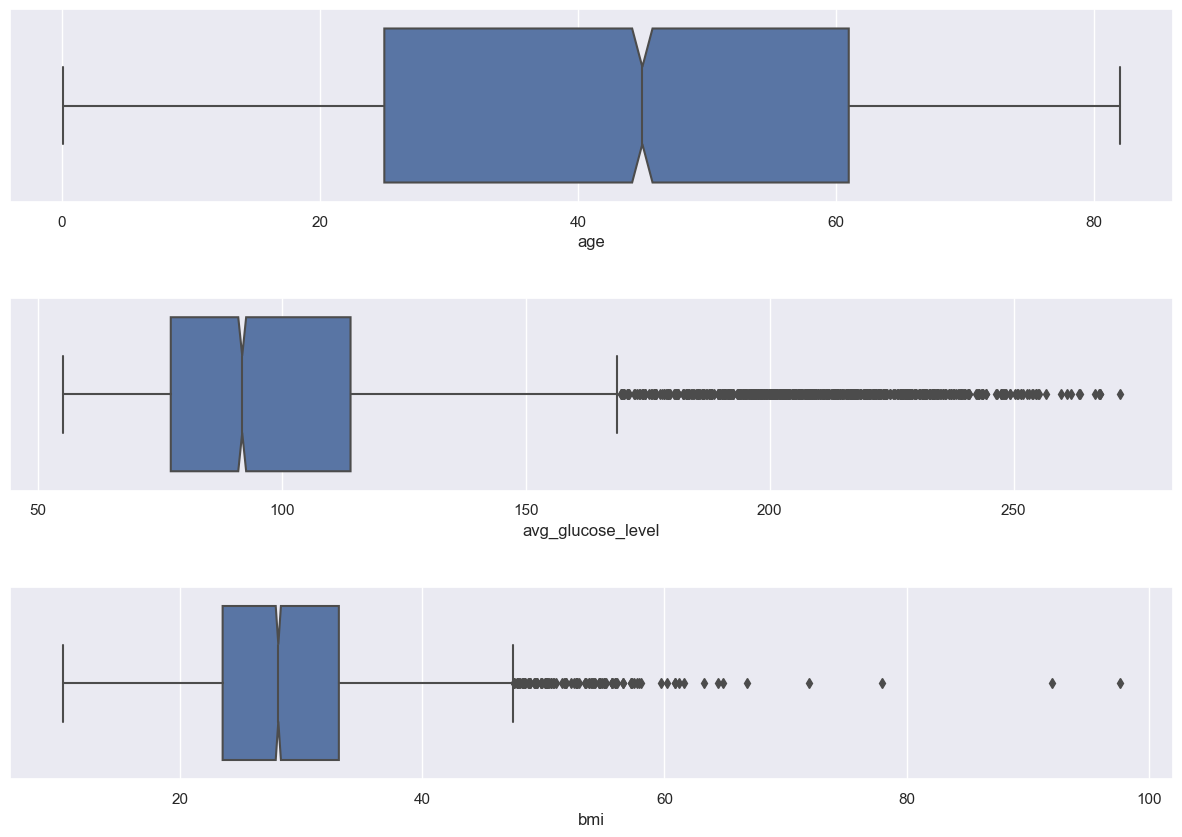

In [14]:
#Creating Subplot for features
fig, ax = plt.subplots(nrows = 3,            #Number of Rows
                       ncols = 1,            #Number of Columns
                       figsize = (15, 10))   #Size of each subplot

#Adjusting padding between the 3 subplots for readability
fig.subplots_adjust(hspace=0.5)


#Adding Age subplot
sns.boxplot(ax=ax[0], data=ea_df, x='age', notch=True);

#Adding avg Glucose Level subplot
sns.boxplot(ax=ax[1], data=ea_df, x='avg_glucose_level', notch=True);

#Adding bmi subplot
sns.boxplot(ax=ax[2], data=ea_df, x='bmi', notch=True);

- Age
    - Fairly even distribution, some very low values that may need to be looked at more
    - Could just be thorough sampling and including a very young baby
- Average Glucose Level
    - Majority of data lies between about 50 and 170
    - Quite a few outliers reaching over 250
    - Mean of around 90, 50% of the data between about 75 and 115
- BMI
    - Majority of data between about 5 and 50
    - Outliers for the most part are not much higher than the max of our boxplot
    - There are a few outliers up around 90 which may need to be addressed, might not be realistic value
    - Most of the data appears to be normal, with the average BMI in the high 20s

In [15]:
#Changing hypertension and heart disease responses from 1/0 to yes/no
ea_df['hypertension'] = ea_df['hypertension'].replace({0: "No",
                                                       1: "Yes"})
ea_df['heart_disease'] = ea_df['heart_disease'].replace({0: "No",
                                                         1: "Yes"})
ea_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,No,Yes,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,No,No,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,No,Yes,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,No,No,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,Yes,No,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


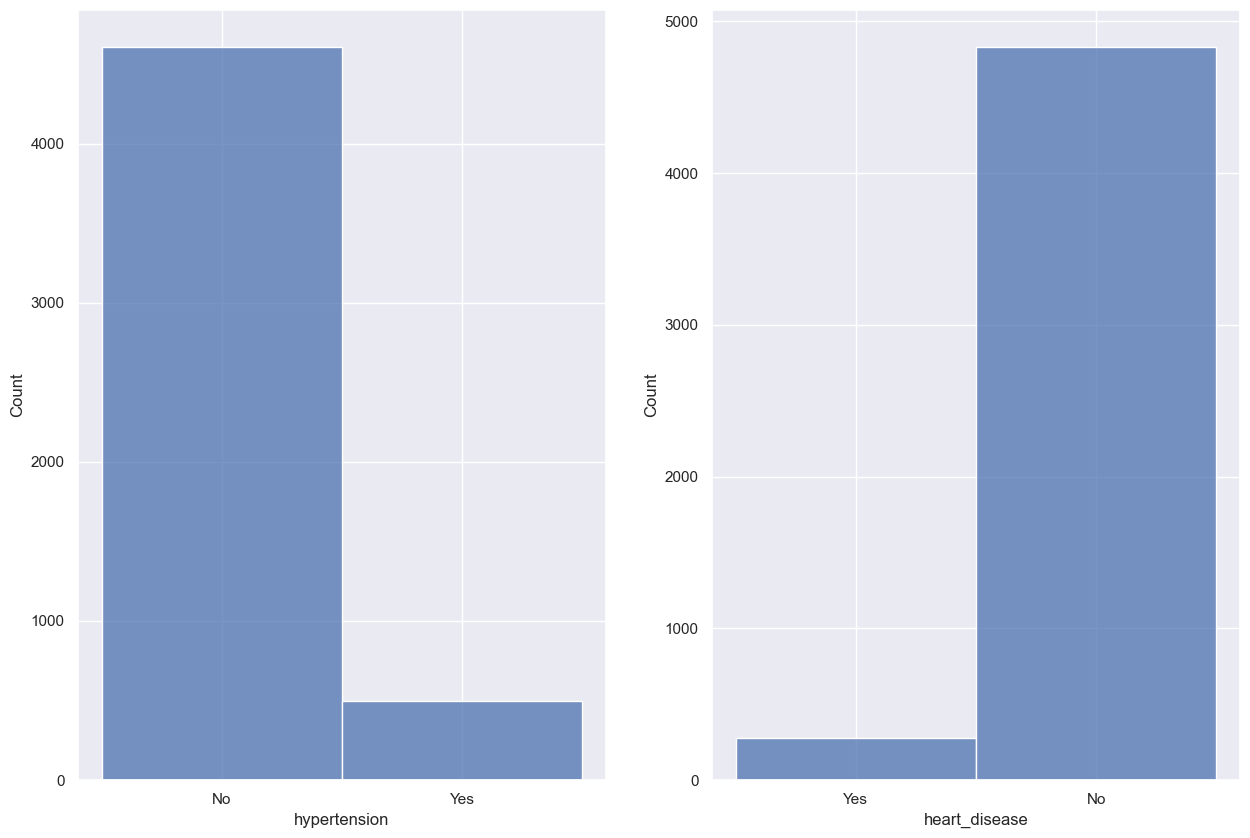

In [16]:
#Creating Subplot for features
fig, ax = plt.subplots(nrows = 1,            #Number of Rows
                       ncols = 2,            #Number of Columns
                       figsize = (15, 10))   #Size of each subplot

#Adding hypertension to subplots
sns.histplot(ax=ax[0], data=ea_df, x='hypertension');

#Adding heart disease to subplots
sns.histplot(ax=ax[1], data=ea_df, x='heart_disease');

- Hypertension
    - Majority of responses had no hypertension, may need to be considered during modeling later
- Heart Disease
    - Again, majority of responses had no history of heart disease. Also may need to be considered during modeling

### Target

In [17]:
#Changing 0's and 1's to "yes" or "no" for graphing
ea_df['stroke'] = ea_df['stroke'].replace({0: "No",
                                           1: "Yes"})

ea_df['stroke'].head()

0    Yes
1    Yes
2    Yes
3    Yes
4    Yes
Name: stroke, dtype: object

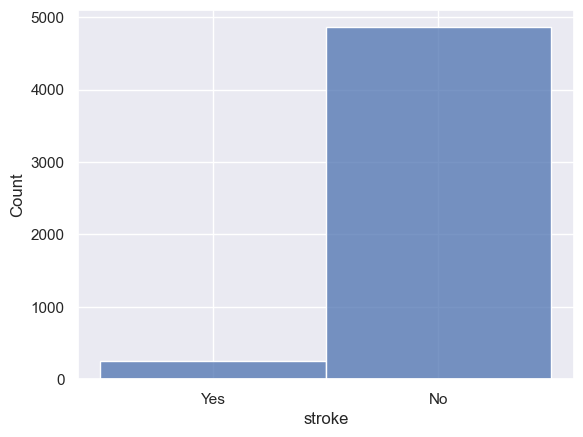

In [18]:
#Plotting
sns.histplot(data=ea_df, x='stroke');

- We can see the large majority of the people did not have a stroke
    - This will need to be taken into account during machine learning models

In [19]:
ea_df['stroke'].value_counts()

No     4861
Yes     249
Name: stroke, dtype: int64

### Multivariate Analysis


In [20]:
#Copying original dataframe
mv_df = df.copy()
mv_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [21]:
#Changing married column to 1 for yes, 0 for no
mv_df['ever_married'] = mv_df['ever_married'].replace({'Yes': 1,
                                                 'No': 0})

mv_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,1,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,1,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,1,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,1,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,1,Self-employed,Rural,174.12,24.0,never smoked,1


#### Heatmap for Correlations

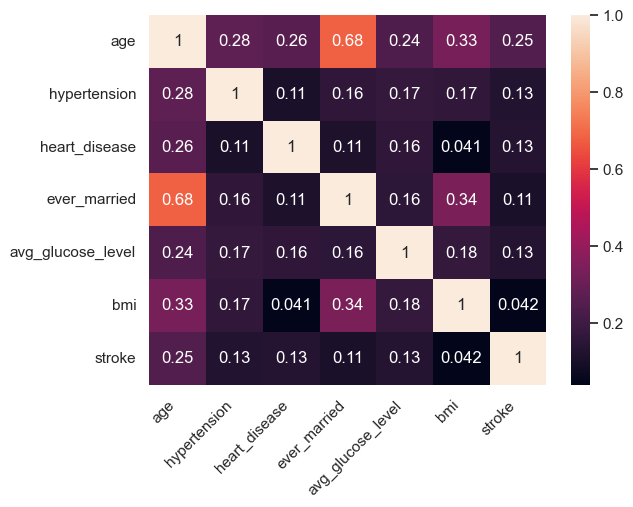

In [22]:
#Finding correlations between numerical variables
corr = mv_df[['age', 'hypertension', 'heart_disease', 'ever_married',
              'avg_glucose_level', 'bmi', 'stroke']].corr()

#Creating heatmap of correlations
sns.heatmap(corr, annot = True)

#rotating and shifting labels for readability
plt.xticks(rotation=45,ha = 'right');

- No large correlations between our target, stroke, and the other features of our data
    - Weak positive correlation between age and stroke
- Strong positive correlation between age and whether or not the person was married
- Weak positive correlation between age and bmi
- Weak positive correlation between bmi and if the person was married

#### Multivariate Visualizations

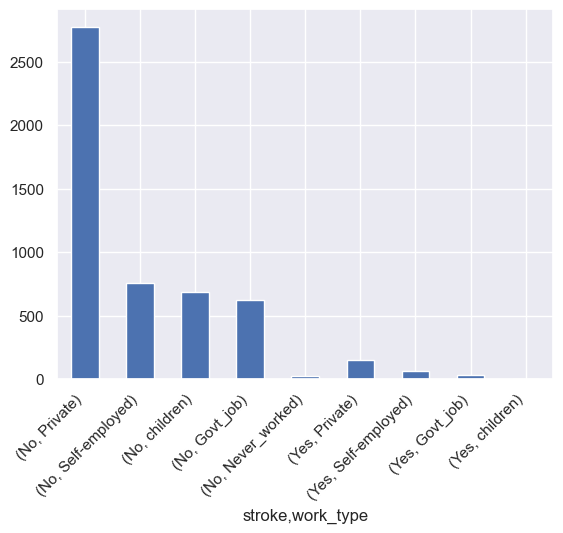

In [23]:
ea_df.groupby('stroke')['work_type'].value_counts().plot(kind='bar');
plt.xticks(rotation=45, ha='right');

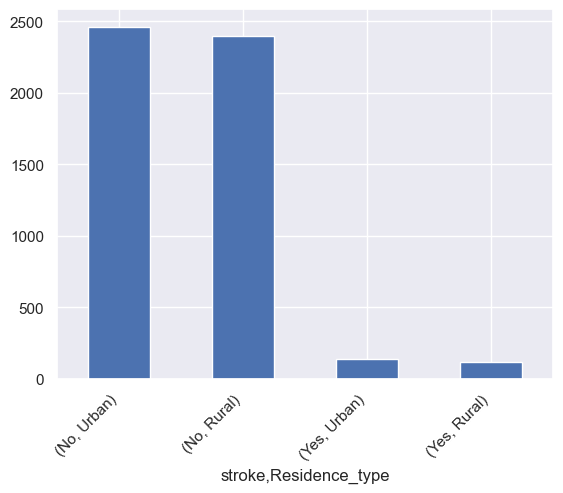

In [24]:
ea_df.groupby('stroke')['Residence_type'].value_counts().plot(kind='bar');
plt.xticks(rotation=45, ha='right');

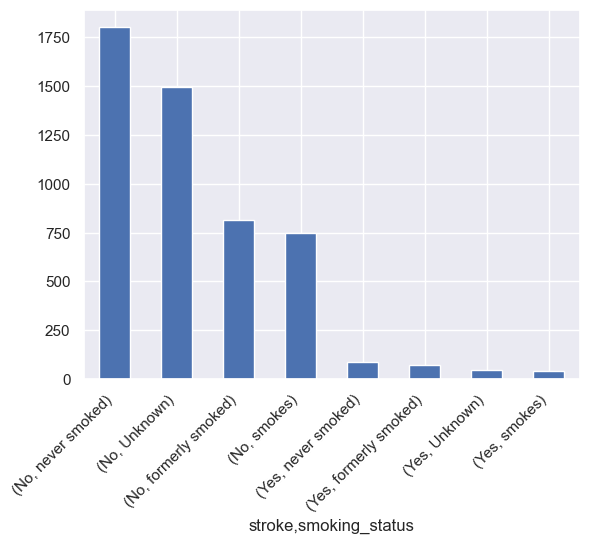

In [25]:
ea_df.groupby('stroke')['smoking_status'].value_counts().plot(kind='bar');
plt.xticks(rotation=45, ha='right');

- Work Type
    - People who recorded a "Private" work type tended to have the highest number of strokes, could be skewed because it is such a large range of jobs
    - Self-Employed people had a very small amount more strokes than people who worked a government job
    - People who worked with children recorded very little (2) strokes
- Residence Type
    - There seems to be extremely little if any correlation between residence type and whether or not the person had a stroke or not
    - Very even split between rural and urban
- Smoking Status
    - If we combine people who have or have previously smoked, there is a small amount more of these people who have had strokes versus non smokers

### Key Trends

#### Trend 1

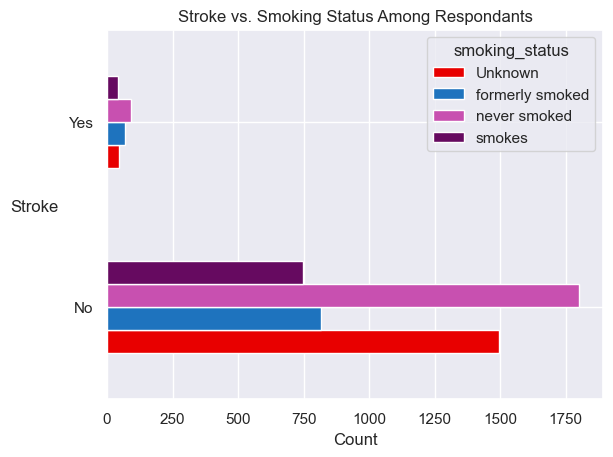

In [26]:
#Initial graph
ea_df.groupby('stroke')['smoking_status'].value_counts().unstack().plot(
                                kind='barh', color=['#E80000',    #Red
                                                    '#1E73BE',    #Blue
                                                    '#C850B0',    #Pinkish
                                                    '#660A60']);  #Purple
                                                    

#Adding label to x axis
plt.xlabel('Count');

#Rotating y label
plt.ylabel('Stroke', rotation=0, labelpad=25);

#Adding title
plt.title('Stroke vs. Smoking Status Among Respondants');

- People that have had a stroke are slightly more likely to currently or formerly smoke than non smokers.
- More non-smokers have not had strokes compared to current or former smokers.
- Unknown entries may swing the data more drastically in one direction, especially with the small amount of data we have for people who have had a stroke.

#### Trend 2

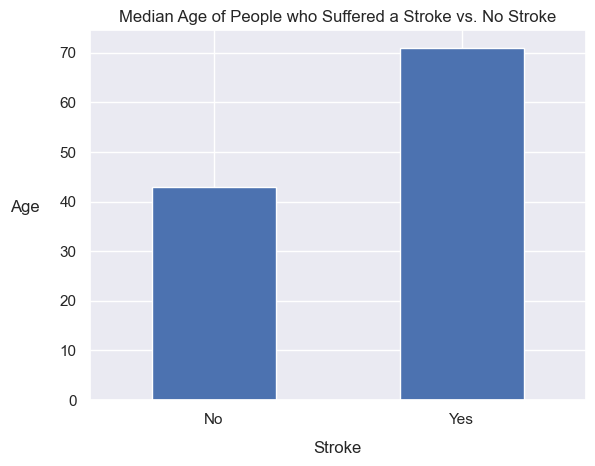

In [35]:
#Getting median value of age for both stroke categories
ea_df.groupby('stroke')['age'].median().plot(kind='bar')

#Making x label capitalized
plt.xlabel('Stroke', labelpad=10)
#Rotatingi x tick labels for readability
plt.xticks(rotation=0)

#Adding y label
plt.ylabel('Age', rotation=0, labelpad=25)

#Adding title
plt.title('Median Age of People who Suffered a Stroke vs. No Stroke');

- People who did not have a stroke have a fairly average age of just over 40.
- People who did have a stroke have a median age of just over 70.
- We can see the median age of people who have had a stroke is much higher, about 30 years, than people who have not had a stroke. 